# CS435 Assignment 1
## **Title:** Linear Regression on Student Performance

**Presented by:**
- Joud fahad alharbi 431201479  
- Aleen Alqwaifel 431201500  
- Bushra Ali alhusyani 421201987  
- Reema Alfehaid 431201292  
- Kadi Alaowimer 411214150

**Goal:** Apply Linear Regression to a real-world dataset (`student_performance.csv`) to predict the final marks.

**Dataset Source:**
https://www.kaggle.com/datasets/nabeelqureshitiii/student-performance-dataset


**Notebook Outline (mirrors course template):**
1. Imports
2. Data Upload & Loading
3. Dataset Overview
4. Cleaning & Preprocessing
5. Feature/Target Selection
6. Train/Validation/Test Split (60/20/20)
7. Train Linear Regression
8. Validation Metrics
9. Final Model (Train+Val) & Test Metrics
10. Coefficients & Top Features
11. Visualizations (Actual vs Predicted)


## 1) Import Required Libraries
We import libraries for data handling (Pandas, NumPy), visualization (Matplotlib), and modeling/evaluation (scikit‑learn).


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)


## 2) Data Upload & Loading
Upload `student_performance.csv`.



In [ ]:
from google.colab import files

# Upload dataset (choose student_performance.csv)
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded.keys())))
print('Dataset loaded successfully! Shape:', df.shape)
df.head()


Saving student_performance.csv to student_performance (1).csv
Dataset loaded successfully! Shape: (1000000, 6)


,student_id,weekly_self_study_hours,attendance_percentage,class_participation,total_score,grade
0,1,18.5,95.6,3.8,97.9,A
1,2,14.0,80.0,2.5,83.9,B
2,3,19.5,86.3,5.3,100.0,A
3,4,25.7,70.2,7.0,100.0,A
4,5,13.4,81.9,6.9,92.0,A


## 3) Dataset Overview
Inspect data types, basic stats, and missing values.


In [ ]:
print('\nInfo:')
print(df.info())
print('\nDescribe (numeric):')
display(df.describe())
print('\nMissing values per column:')
print(df.isna().sum())



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   student_id               1000000 non-null  int64  
 1   weekly_self_study_hours  1000000 non-null  float64
 2   attendance_percentage    1000000 non-null  float64
 3   class_participation      1000000 non-null  float64
 4   total_score              1000000 non-null  float64
 5   grade                    1000000 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 45.8+ MB
None

Describe (numeric):


,student_id,weekly_self_study_hours,attendance_percentage,class_participation,total_score
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,15.029127,84.711046,5.985203,84.283845
std,288675.278933,6.899431,9.424143,1.956421,15.432969
min,1.000000,0.000000,50.000000,0.000000,9.400000
25%,250000.750000,10.300000,78.300000,4.700000,73.900000
50%,500000.500000,15.000000,85.000000,6.000000,87.500000
75%,750000.250000,19.700000,91.800000,7.300000,100.000000
max,1000000.000000,40.000000,100.000000,10.000000,100.000000



Missing values per column:
student_id                 0
weekly_self_study_hours    0
attendance_percentage      0
class_participation        0
total_score                0
grade                      0
dtype: int64


## 4) Cleaning & Preprocessing
- Impute numeric missing values with the median
- One-hot encode categorical columns (drop_first=True)
- Remove exact duplicate rows
- All features are numeric and roughly on comparable scales; scaling does not affect OLS coefficients materially.


In [ ]:
# Separate numeric and non-numeric for imputation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print('Numeric columns:', numeric_cols)
print('Non-numeric columns:', non_numeric_cols)

# Impute numeric columns with median
for c in numeric_cols:
    df[c] = df[c].fillna(df[c].median())

# Encode categoricals if any
df = pd.get_dummies(df, columns=non_numeric_cols, drop_first=True)

# Drop duplicates
dups_before = df.duplicated().sum()
df = df.drop_duplicates().reset_index(drop=True)
dups_after = df.duplicated().sum()
print(f'Duplicates removed: {dups_before - dups_after}')
print('Shape after preprocessing:', df.shape)


Numeric columns: ['student_id', 'weekly_self_study_hours', 'attendance_percentage', 'class_participation', 'total_score']
Non-numeric columns: ['grade']
Duplicates removed: 0
Shape after preprocessing: (1000000, 9)


## 5) Feature/Target Selection
We will choose **Total Score** column as the target.


In [ ]:
TARGET_COL = 'total_score'

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]
print('X shape:', X.shape, '| y shape:', y.shape)


X shape: (1000000, 8) | y shape: (1000000,)


## 6) Train/Validation/Test Split (60/20/20)
We use a held-back validation set to avoid overfitting of the model.

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f'Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}')


Train: (600000, 8), Validation: (200000, 8), Test: (200000, 8)


## 7) Train Linear Regression
Fit a simple Linear Regression model on the training set.


In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
print('Model trained on training set.')


Model trained on training set.


## 8) Validation Performance
Evaluate on the validation set using MAE, MSE, RMSE, and R².


In [ ]:
y_val_pred = linreg.predict(X_val)

val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = math.sqrt(val_mse)
val_r2 = r2_score(y_val, y_val_pred)

print('\nValidation Set Metrics:')
print(f'MAE : {val_mae:.4f}')
print(f'MSE : {val_mse:.4f}')
print(f'RMSE: {val_rmse:.4f}')
print(f'R²  : {val_r2:.4f}')



Validation Set Metrics:
MAE : 3.3367
MSE : 16.2225
RMSE: 4.0277
R²  : 0.9317


## 9) Final Model (Train + Validation) & Test Metrics
Combine training and validation sets, retrain, then evaluate on the test set.


In [ ]:
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = pd.concat([y_train, y_val], axis=0)

final_model = LinearRegression()
final_model.fit(X_trval, y_trval)

y_test_pred = final_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = math.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print('\nTest Set Metrics:')
print(f'MAE : {test_mae:.4f}')
print(f'MSE : {test_mse:.4f}')
print(f'RMSE: {test_rmse:.4f}')
print(f'R²  : {test_r2:.4f}')



Test Set Metrics:
MAE : 3.3404
MSE : 16.2398
RMSE: 4.0299
R²  : 0.9319


## 10) Coefficients & Top Features
Inspect linear model coefficients to understand feature influence.


In [ ]:
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': final_model.coef_})
coef_df_sorted = coef_df.sort_values(by='Coefficient', ascending=False)
display(coef_df_sorted.head(10))
display(coef_df_sorted.tail(10))


,Feature,Coefficient
1,weekly_self_study_hours,5.013796e-01
0,student_id,-2.320936e-09
2,attendance_percentage,-2.015027e-04
3,class_participation,-5.454325e-04
4,grade_B,-1.445483e+01
5,grade_C,-2.661901e+01
6,grade_D,-3.883110e+01
7,grade_F,-5.156907e+01


,Feature,Coefficient
1,weekly_self_study_hours,5.013796e-01
0,student_id,-2.320936e-09
2,attendance_percentage,-2.015027e-04
3,class_participation,-5.454325e-04
4,grade_B,-1.445483e+01
5,grade_C,-2.661901e+01
6,grade_D,-3.883110e+01
7,grade_F,-5.156907e+01


from matplotlib import pyplot as plt
_df_0['Coefficient'].plot(kind='hist', bins=20, title='Coefficient')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Feature').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Coefficient'].plot(kind='line', figsize=(8, 4), title='Coefficient')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['Feature'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='Coefficient', y='Feature', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## 11) Visualization — Actual vs Predicted
A simple scatter plot to visualize model performance on the test set.


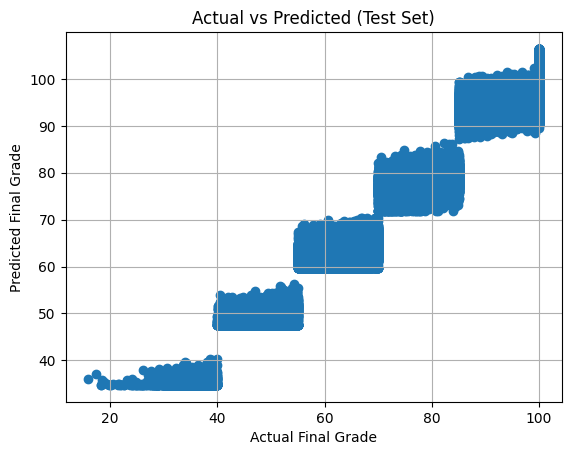

In [ ]:
plt.figure()
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual Final Grade')
plt.ylabel('Predicted Final Grade')
plt.title('Actual vs Predicted (Test Set)')
plt.grid(True)
plt.show()


## 12) Results & Feature Importance (Coefficients)

Below we compute and display the **Linear Regression coefficients** sorted by absolute magnitude to indicate which features have the strongest linear association with the target in the fitted model.

In [21]:
# --- Feature Importance (Linear Regression Coefficients) ---
import numpy as np
import pandas as pd

# Try to find a trained linear regression model among common variable names.
_candidates = []
for _name in ['final_model', 'model', 'lr', 'linear_model', 'linreg', 'reg']:
    try:
        _obj = eval(_name)
        # Accept either a raw LR model (with .coef_) or a Pipeline with a 'model' step
        if hasattr(_obj, 'coef_') or (hasattr(_obj, 'named_steps') and 'model' in _obj.named_steps):
            _candidates.append((_name, _obj))
    except Exception:
        pass

if not _candidates:
    raise NameError("Couldn't find a trained Linear Regression model variable (e.g., final_model, model, lr). "
                    "Please run the training cells first, then re-run this cell.")

_model_name, _model_obj = _candidates[0]

# Extract the underlying LinearRegression estimator and feature names
if hasattr(_model_obj, 'named_steps'):
    _lr = _model_obj.named_steps.get('model', _model_obj)
else:
    _lr = _model_obj

# Heuristically infer feature names from common matrices
if 'X_trval' in globals():
    _feat_names = list(X_trval.columns) if hasattr(X_trval, 'columns') else [f'feat_{i}' for i in range(len(_lr.coef_.ravel()))]
elif 'X_train' in globals():
    _feat_names = list(X_train.columns) if hasattr(X_train, 'columns') else [f'feat_{i}' for i in range(len(_lr.coef_.ravel()))]
else:
    # Fallback if feature matrices are not in scope as DataFrames
    _feat_names = [f'feat_{i}' for i in range(len(np.ravel(_lr.coef_)))]

_coefs = np.ravel(_lr.coef_)
coefs_df = pd.DataFrame({
    'feature': _feat_names,
    'coefficient': _coefs
})
coefs_df['abs_coeff'] = coefs_df['coefficient'].abs()
coefs_df = coefs_df.sort_values('abs_coeff', ascending=False).reset_index(drop=True)

print(f"Using model variable: `{_model_name}`")
display(coefs_df.head(15))

Using model variable: `final_model`


,feature,coefficient,abs_coeff
0,grade_F,-5.156907e+01,5.156907e+01
1,grade_D,-3.883110e+01,3.883110e+01
2,grade_C,-2.661901e+01,2.661901e+01
3,grade_B,-1.445483e+01,1.445483e+01
4,weekly_self_study_hours,5.013796e-01,5.013796e-01
5,class_participation,-5.454325e-04,5.454325e-04
6,attendance_percentage,-2.015027e-04,2.015027e-04
7,student_id,-2.320936e-09,2.320936e-09


from matplotlib import pyplot as plt
_df_46['coefficient'].plot(kind='hist', bins=20, title='coefficient')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_47['abs_coeff'].plot(kind='hist', bins=20, title='abs_coeff')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_48.groupby('feature').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_49.plot(kind='scatter', x='coefficient', y='abs_coeff', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_50['coefficient'].plot(kind='line', figsize=(8, 4), title='coefficient')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_51['abs_coeff'].plot(kind='line', figsize=(8, 4), title='abs_coeff')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_52['feature'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_52, x='coefficient', y='feature', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_53['feature'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_53, x='abs_coeff', y='feature', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_54['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_55['coefficient'].plot(kind='hist', bins=20, title='coefficient')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_56['abs_coeff'].plot(kind='hist', bins=20, title='abs_coeff')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_57.groupby('feature').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_58.plot(kind='scatter', x='index', y='coefficient', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_59.plot(kind='scatter', x='coefficient', y='abs_coeff', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['coefficient']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_60.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('feature')):
  _plot_series(series, series_name, i)
  fig.legend(title='feature', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('coefficient')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['abs_coeff']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_61.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('feature')):
  _plot_series(series, series_name, i)
  fig.legend(title='feature', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('abs_coeff')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_62.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('feature')):
  _plot_series(series, series_name, i)
  fig.legend(title='feature', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_63['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_64['coefficient'].plot(kind='line', figsize=(8, 4), title='coefficient')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_65['abs_coeff'].plot(kind='line', figsize=(8, 4), title='abs_coeff')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_66['feature'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_66, x='index', y='feature', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_67['feature'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_67, x='coefficient', y='feature', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_68['feature'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_68, x='abs_coeff', y='feature', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)